# Import library

In [1]:
import sys
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.applications import Knapsack
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# Define semi-classical Knapsack function

In [2]:
def knapsack_argument(total_value_list, total_weight_list, weight_max):
    max_combination_list_idx = []
    
    length = len(total_value_list[0])
    updated_combination_list_idx = [0] * length
    updated_combination_values = total_value_list[0].copy()
    updated_combination_weights = total_weight_list[0].copy()
    
    for i in range(len(total_value_list)-1):
        values = list(total_value_list[i+1][j]- updated_combination_values[j] for j in range(length))
        weights = list(total_weight_list[i+1][j]- updated_combination_weights[j] for j in range(length))
        max_weight = weight_max - sum(updated_combination_weights) 
    
        prob = Knapsack(values = values, weights = weights, max_weight = max_weight)
        kqp = prob.to_quadratic_program()
        
        mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
        meo = MinimumEigenOptimizer(min_eigen_solver=mes)
        
        result = meo.solve(kqp)
                
        for j in range(len(result.x)):
            if result.x[j] == 1:
                updated_combination_list_idx[j] = i+1
                updated_combination_values[j] = total_value_list[i+1][j]
                updated_combination_weights[j] = total_weight_list[i+1][j]
    
    return updated_combination_list_idx, updated_combination_values, updated_combination_weights

# Define function that makes kanpsack problem to Quadratic Problem with Constraint

In [15]:
def formulate_qp(values, weights, weight_max):
    """
    Formulate the knapsack problem as a quadratic program.

    Args:
        values (list[list[float]]): Value list
        weights (list[list[float]]): Weight list
        weight_max (float): Maximum allowable weight.

    Returns:
        QuadraticProgram: The formulated quadratic program.
    """
    
    num_of_comp = len(values[0])
    num_of_markets = len(values) 
    
    qp = QuadraticProgram("Knapsack Problem")

    # Define binary variables
    for i in range(num_of_comp):      
        for j in range(num_of_markets):
            qp.binary_var(name=f"Market{j}_comp{i}")

    # Objective function: Maximize profits
    linear_terms_dict = {}
    for i in range(num_of_comp):
        for j in range(num_of_markets):
            linear_terms_dict[f"Market{j}_comp{i}"] = values[j][i]
            
    qp.maximize(linear=linear_terms_dict)

    # Constraint: Each item must be in exactly one market
    for i in range(num_of_comp):
        qp.linear_constraint(
            linear={f"Market{j}_comp{i}": 1 for j in range(num_of_markets)},
            sense="==",
            rhs=1,
            name=f"state_constraint_{i}",
        )

    # Constraint: Total weight must not exceed wieght_max
    weight_terms_dict = {}
    for i in range(num_of_comp):
        for j in range(num_of_markets):
            weight_terms_dict[f"Market{j}_comp{i}"] = weights[j][i]
    
    qp.linear_constraint(
        linear=weight_terms_dict,
        sense="<=",
        rhs = weight_max,
        name="weight_constraint",
    )

    return qp

def solve_qp_with_qiskit(values, weights, weight_max):
    """
    Solve the quadratic program using Qiskit's optimization solvers.

    Args:
        values (list[list[float]]): Revenue values for markets.
        weights (list[list[float]]): Weight values for markets.
        weight_max (float): Maximum allowable weight.

    Returns:
        dict: Solution details including selected items and total revenue.
    """

    qp = formulate_qp(values, weights, weight_max)

    print(qp.prettyprint())  # Optional: Print the formulated QP

    qaoa = QAOA(sampler = Sampler(), optimizer=COBYLA())
    optimizer = MinimumEigenOptimizer(qaoa)

    result = optimizer.solve(qp)
    solution = result.x

    total_value = 0
    assignments = []

    num_of_comp = len(values[0])
    num_of_markets = len(values)

    for i in range(num_of_comp):
        for j in range(num_of_markets):
            if solution[num_of_markets * i + j] == 1:
                total_value += values[j][i]
                assignments.append(f"Market{j}_comp{i}")
                break

    return {
        "solution": solution,
        "assignments": assignments,
        "total_value": total_value,
        "ansatz": qaoa.ansatz
        }


# Knapsack Solver Program

In [17]:
while True:
    num_of_options = input("How many comparative groups do you want to create?: (press enter if you want to quit) ")
    if num_of_options == "":
        try:
            sys.exit()  # 프로그램 종료
            print(1)  # 실행되지 않음
        except SystemExit:
            pass  # SystemExit 예외를 무시
    if num_of_options.isdigit():  # 숫자인지 확인
        num_of_options = int(num_of_options)
        break
    else:
        print("Please enter a valid number.")

while True:
    num_of_elements = input("How many elements are in each group?: (press enter if you want to quit) ")
    if num_of_elements == "":
        try:
            sys.exit()  # 프로그램 종료
            print(1)  # 실행되지 않음
        except SystemExit:
            pass  # SystemExit 예외를 무시
    if num_of_elements.isdigit():  # 숫자인지 확인
        num_of_elements = int(num_of_elements)
        break
    else:
        print("Please enter a valid number.")
        
while True:
    weight_max = input("What is the maximum allowable weights?: (press enter if you want to quit) ")
    if weight_max == "":
        try:
            sys.exit()  # 프로그램 종료
            print(1)  # 실행되지 않음
        except SystemExit:
            pass  # SystemExit 예외를 무시
    try:
        weight_max = float(weight_max)
        break
    except ValueError:
        print("Please enter a valid number.")


total_value_list = []
total_weight_list = []

for i in range(num_of_options):
    while True:
        values = input(f"Input values for group {i} out of {num_of_options} gropus (separate by spaces, {num_of_elements} values): ")
        value_list = values.split()  # 입력을 공백으로 나눔
        if len(value_list) != num_of_elements:  # 입력 길이 확인
            print(f"Please input exactly {num_of_elements} values.")
            continue
        try:
            value_list = [float(value) for value in value_list]  # 실수 변환
            break
        except ValueError:
            print("All values must be numbers. Please try again.")
            
    while True:
        weights = input(f"Input weights for group {i} out of {num_of_options} gropus (separate by spaces, {num_of_elements} values): ")
        weight_list = weights.split()  # 입력을 공백으로 나눔
        if len(weight_list) != num_of_elements:  # 입력 길이 확인
            print(f"Please input exactly {num_of_elements} weights.")
            continue
        try:
            weight_list = [float(weight) for weight in weight_list]  # 실수 변환
            break
        except ValueError:
            print("All weights must be numbers. Please try again.")

    total_value_list.append(value_list)
    total_weight_list.append(weight_list)

# n번 인덱스는 n번째 비교균을 의미
print("Total value list:", total_value_list)
print("Total weight list:", total_weight_list)
    
# kanpsack argument   
list_combination_idx, combination_values, combination_weights = knapsack_argument(total_value_list,total_weight_list, weight_max)
print(f"values : {combination_values}, weights: {combination_weights}")
print(list_combination_idx)
print("Total value:", sum(combination_values))


print("\n\nThe result above came from qiskit simulatoer.\nNow, we will compare the result with the real quantum computer.")

qcomp_result = solve_qp_with_qiskit(total_value_list, total_weight_list, weight_max)
print("Solution:", qcomp_result["solution"])
print("Assignments:", qcomp_result["assignments"])
print("Total Profit:", qcomp_result["total_value"])


Total value list: [[3.0, 5.0, 2.0], [7.0, 1.0, 6.0], [8.0, 2.0, 4.0]]
Total weight list: [[2.0, 3.0, 5.0], [4.0, 2.0, 1.0], [3.0, 4.0, 2.0]]


C:\Users\kimhw\AppData\Local\Temp\ipykernel_32736\201519569.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
C:\Users\kimhw\AppData\Local\Temp\ipykernel_32736\201519569.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  mes = QAOA(sampler=Sampler(), optimizer=COBYLA())


values : [8.0, 5.0, 6.0], weights: [3.0, 3.0, 1.0]
[2, 0, 1]
Total value: 19.0


The result above came from qiskit simulatoer.
Now, we will compare the result with the real quantum computer.
Problem name: Knapsack Problem

Maximize
  3*Market0_comp0 + 5*Market0_comp1 + 2*Market0_comp2 + 7*Market1_comp0
  + Market1_comp1 + 6*Market1_comp2 + 8*Market2_comp0 + 2*Market2_comp1
  + 4*Market2_comp2

Subject to
  Linear constraints (4)
    Market0_comp0 + Market1_comp0 + Market2_comp0 == 1  'state_constraint_0'
    Market0_comp1 + Market1_comp1 + Market2_comp1 == 1  'state_constraint_1'
    Market0_comp2 + Market1_comp2 + Market2_comp2 == 1  'state_constraint_2'
    2*Market0_comp0 + 3*Market0_comp1 + 5*Market0_comp2 + 4*Market1_comp0
    + 2*Market1_comp1 + Market1_comp2 + 3*Market2_comp0 + 4*Market2_comp1
    + 2*Market2_comp2 <= 10  'weight_constraint'

  Binary variables (9)
    Market0_comp0 Market1_comp0 Market2_comp0 Market0_comp1 Market1_comp1
    Market2_comp1 Market0_comp2 Market1_c

C:\Users\kimhw\AppData\Local\Temp\ipykernel_32736\834813021.py:73: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa = QAOA(sampler = Sampler(), optimizer=COBYLA())


Solution: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Assignments: ['Market2_comp0', 'Market0_comp1', 'Market1_comp2']
Total Profit: 19.0


# Making Quantum Circuit of QAOA Ansatz

c:\Users\kimhw\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\kimhw\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


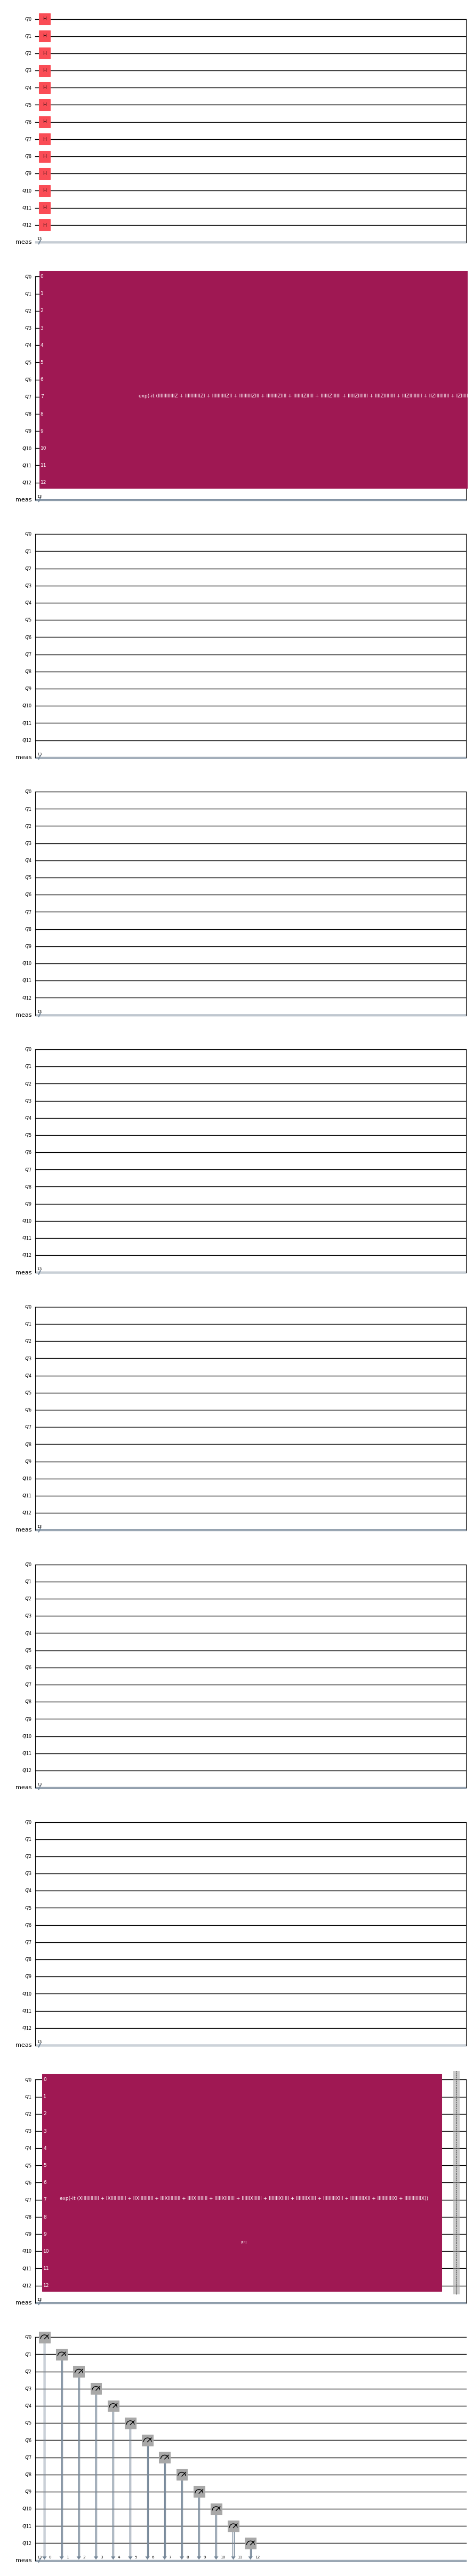

In [34]:
qcomp_result['ansatz'].draw('mpl', style='iqx', scale=0.5)

## Check axuiliary qubits among 13 qubits

In [ ]:
logical_qubits = list(range(9))  # 논리적 변수의 큐빗 인덱스

total_qubits = range(candidate_circuit.num_qubits)
auxiliary_qubits = [q for q in total_qubits if q not in logical_qubits]
print("Auxiliary qubits:", auxiliary_qubits)

# Optimize Quantum Circuit 

AerSimulator('aer_simulator')


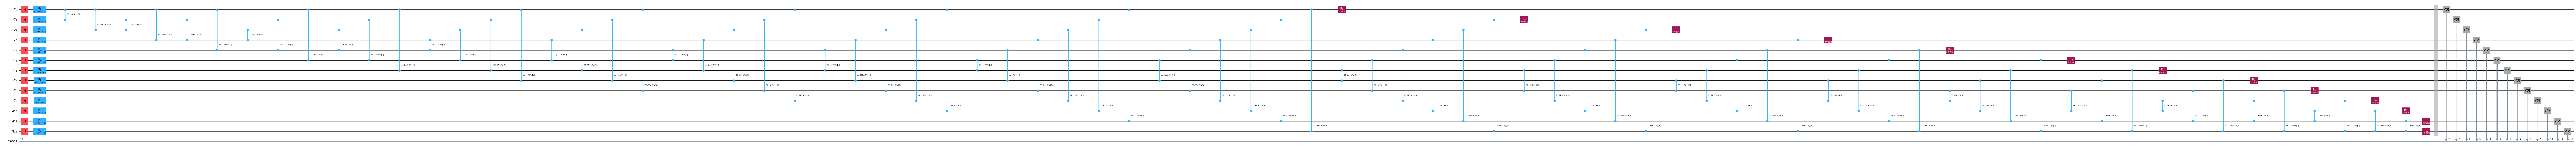

In [43]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Generate a simulator
backend = AerSimulator()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(qcomp_result['ansatz'])
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [55]:
print(candidate_circuit.parameters)

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


# Run the circuit using Quantum Computer(IBM Chip Eagle in Yonsei Univerisity)

In [105]:
# 파라미터 값 설정
param_values = [[0.5, 1.2]]  # 각 회로에 대한 파라미터 값 리스트

# Sampler 실행
sampler = Sampler()
job = sampler.run([candidate_circuit], parameter_values=param_values, shots=int(1e6))  # 올바른 형식
result = job.result()

# 결과 확인
print(result)


C:\Users\kimhw\AppData\Local\Temp\ipykernel_32736\849405722.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


SamplerResult(quasi_dists=[{0: np.float64(2.7e-05), 1: np.float64(7.1e-05), 2: np.float64(1e-06), 3: np.float64(6.3e-05), 4: np.float64(4.5e-05), 5: np.float64(6.1e-05), 6: np.float64(4e-06), 7: np.float64(5.1e-05), 8: np.float64(0.000578), 9: np.float64(5.3e-05), 10: np.float64(7e-06), 11: np.float64(6.4e-05), 12: np.float64(2.1e-05), 13: np.float64(4.6e-05), 14: np.float64(3.3e-05), 15: np.float64(1.9e-05), 16: np.float64(0.000142), 17: np.float64(3.8e-05), 18: np.float64(1.2e-05), 19: np.float64(1.5e-05), 20: np.float64(0.000369), 21: np.float64(0.000145), 22: np.float64(0.000592), 23: np.float64(1.9e-05), 24: np.float64(0.000732), 25: np.float64(4.9e-05), 26: np.float64(0.000363), 27: np.float64(8.3e-05), 28: np.float64(9.2e-05), 29: np.float64(5.4e-05), 30: np.float64(0.000155), 31: np.float64(8.6e-05), 32: np.float64(9e-06), 33: np.float64(1e-05), 34: np.float64(1.6e-05), 35: np.float64(1e-06), 36: np.float64(3.1e-05), 37: np.float64(6e-05), 38: np.float64(6.9e-05), 39: np.float6

In [106]:
# 측정 결과의 확률 분포 가져오기
quasi_dists = result.quasi_dists[0]  # 첫 번째 회로의 결과
print("Quasi-probability distribution:", quasi_dists)

Quasi-probability distribution: {0: np.float64(2.7e-05), 1: np.float64(7.1e-05), 2: np.float64(1e-06), 3: np.float64(6.3e-05), 4: np.float64(4.5e-05), 5: np.float64(6.1e-05), 6: np.float64(4e-06), 7: np.float64(5.1e-05), 8: np.float64(0.000578), 9: np.float64(5.3e-05), 10: np.float64(7e-06), 11: np.float64(6.4e-05), 12: np.float64(2.1e-05), 13: np.float64(4.6e-05), 14: np.float64(3.3e-05), 15: np.float64(1.9e-05), 16: np.float64(0.000142), 17: np.float64(3.8e-05), 18: np.float64(1.2e-05), 19: np.float64(1.5e-05), 20: np.float64(0.000369), 21: np.float64(0.000145), 22: np.float64(0.000592), 23: np.float64(1.9e-05), 24: np.float64(0.000732), 25: np.float64(4.9e-05), 26: np.float64(0.000363), 27: np.float64(8.3e-05), 28: np.float64(9.2e-05), 29: np.float64(5.4e-05), 30: np.float64(0.000155), 31: np.float64(8.6e-05), 32: np.float64(9e-06), 33: np.float64(1e-05), 34: np.float64(1.6e-05), 35: np.float64(1e-06), 36: np.float64(3.1e-05), 37: np.float64(6e-05), 38: np.float64(6.9e-05), 39: np.f

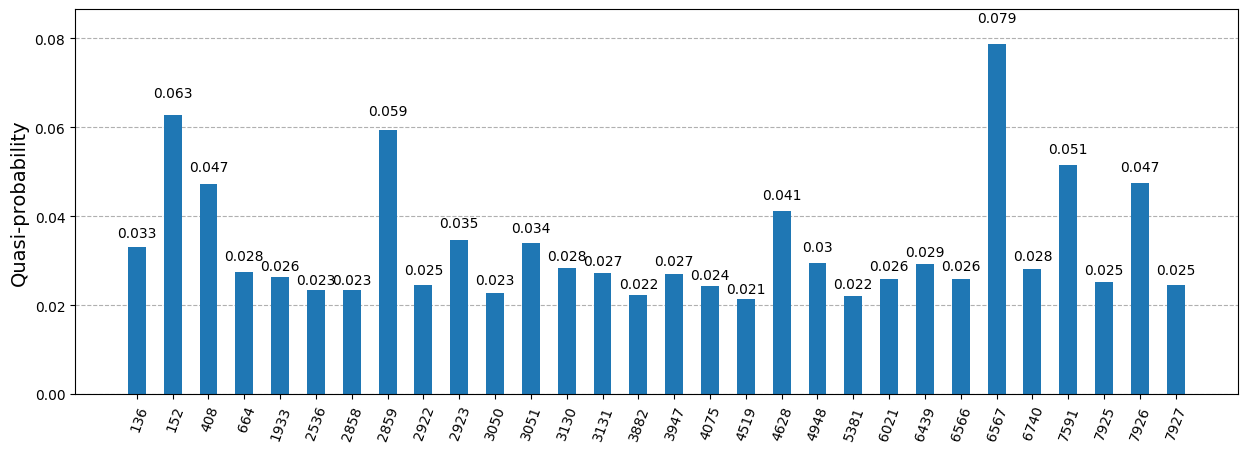

In [107]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
top_30_results = dict(sorted(quasi_dists.items(), key=lambda item: item[1], reverse=True)[:30])

# 히스토그램 생성 및 크기 조정
plot_histogram(top_30_results, figsize=(15, 5))  # 가로 10, 세로 5로 설정
plt.show()